In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import jax 
import jax.numpy as jnp

from jax.example_libraries import stax
from jax.example_libraries import optimizers

from jax.example_libraries.stax import Dense, Relu, Tanh

Read [Simple and Scalable Predictive Uncertainty
Estimation using Deep Ensembles](https://proceedings.neurips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf). For this exercise, we will implement the toy regression problem in which we want to fit the function $f(x) = x^3$ through noisy observations, ie: $y = x^3 + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 3^2)$.

In [ ]:
def toy_dataset(key, num_samples_train=20, minval_train=-4, maxval_train=4, num_samples_test=100, minval_test=-6,  maxval_test=6):
  def f(x):
    return x**3

  key, subkey = jax.random.split(key)
  Xtrain = jax.random.uniform(key, shape=(num_samples_train,), minval=minval_train, maxval=maxval_train)
  noises = jax.random.normal(subkey, shape=(num_samples_train,))*3
  Ytrain = f(Xtrain) + noises

  Xtest = jnp.linspace(minval_test, maxval_test, num_samples_test)
  Ytest = f(Xtest)

  return (Xtrain[:, jnp.newaxis], Ytrain), (Xtest[:, jnp.newaxis], Ytest), f

In [ ]:
out = predict_fn(params, input)

In [ ]:
mean = out[:, :10] 
variance = out[:, 10:]

An important design consideration of the Deep Ensemble paper is to use a two-headed network outputting the mean and variance of a Gaussian distribution given an input. We use these two outputs to then compute the log-likelihood of the data under the Gaussian assumption. Our loss becomes: 

\begin{align*}
\mathcal{L}(\theta; \mathcal{D}) \triangleq \frac{1}{2|\mathcal{D}|} \sum_{i=1}^{|\mathcal{D}|}\left(\log \sigma^2(x_i; \theta) + \frac{(y_i - \mu_\theta(x_i))^2}{\sigma_\theta^2(x_i)}\right) \enspace ,
\end{align*}
which departs slightly from the usual MSE loss that you have been using so far. Furthermore, we use the softplus function to ensure that the variance output is nonnegative and add a minimum value of $1e^{-6}$ for numerical stability. 

In [ ]:
def nll_loss(params, inputs, targets, predict_fn):
  """ Compute the negative log likelihood of our model under the Gaussian assumption.
  Args:
    params (list): list of parameters of a predictor in the ensemble
    inputs (jnp.ndarray): batch of input observation (xs)
    targets (jnp.ndarray): batch of targets (ys)
    predict_fn (function): neural network function predict_fn(params, inputs)
  Returns: 
    Mean log likelihood of the parameters for the given data
  """
  # IMPLEMENT the loss above loss function
    return 1/(2*inputs.shape[0]) * jnp.sum(jnp.log(variance) + (targets-mean)**2/variance)

We learn each predictor through gradient descent using the [Adam optimizer](https://arxiv.org/abs/1412.6980). Since members of the ensemble are trained independently, we will be able to vmap the training procedure across datasets: ie will will vmap a dataset of datasets. Let's start by implementing the training loop:

In [ ]:
def train(loss, init_params, dataset, step_size, num_steps):
  inputs, targets = dataset
  opt_init, opt_update, get_params = optimizers.adam(step_size=step_size)
  @jax.jit
  def step(opt_state, i):
    val, pg = jax.value_and_grad(loss)(get_params(opt_state), inputs, targets, predict_fn)
    opt_state = opt_update(i, pg, opt_state)
    return opt_state, val
  opt_state, values = jax.lax.scan(step, opt_init(init_params), xs=jnp.arange(num_steps))
  return get_params(opt_state), values

We train each predictor using the above optimization procedure through vmap. A crucial component of the deep ensemble paper is the use of adversarial examples to enhance the quality of the uncertainty estimation. More precisely, we generate an augmented dataset $\mathcal{D}'$ by perturbing the original data as follows: 
\begin{align*}
x_i' = x_i + \epsilon \text{sign}\left( D_1 \mathcal{L}(\theta_0^{(m)}, x_i, y_i)\right), \enspace \forall (x_i,y_i) \in \mathcal{D} \enspace ,
\end{align*}
where $\theta_0^{(m)}$ are the initial parameters of a given model $m$ in the ensemble. 

In [ ]:
def train_ensemble(key, dataset, num_models, eps_adversarial, step_size, num_steps):
  """ Train a deep ensemble using adversarial samples and random reshuffling 

  Args: 
    key: key to be split when initializing the network and shuffling the data
    dataset (tuple): pair of jnp.ndarray (inputs, targets)
    num_models (int): number of models in the ensemble
    eps_adversarial (float): epsilon coefficient used to generate adversarial inputs
    step_size (float): step size used in training each member of the ensemble 
    num_steps (int): number of optimization steps to run

  Returns:
    A tuple of optimized parameters for each member and the corresponding training losses. 
  """
  inputs, targets = dataset

  def adversarial_train(key):
    key, subkey = jax.random.split(key)
    _, init_params = init_fn(key, (-1,1))
    # IMPLEMENT: 
    # 1. Create a new set of adversarial examples by perturbing the original 
    # inputs in the direction given by the sign of the gradient of the loss with 
    # respect to its inputs. 

    inputs = jax.random.shuffle(subkey, inputs)
    dir = jnp.sign(jax.grad(nll_loss(init_params, inputs, targets, predict_fn)))
    inputs += eps_adversarial * dir

    # 2. Create an augmented dataset
     dataset = (inputs, targets)

    # 3. Compute the negative log likelihood loss on the augmented dataset
    return (dataset, nll_loss(init_params, inputs, targets, predict_fn))

  return jax.vmap(adversarial_train)(jax.random.split(key, num_models))

In [ ]:
key = jax.random.PRNGKey(6541)
(Xtrain, Ytrain), (Xtest, Ytest), f = toy_dataset(key)

In [ ]:
Xtrain.shape

(20, 1)

Per the original paper, we use a network with a dense layer of $50$ units with a relu nonlinearity, which then produces the final two outputs via a dense linear mapping. 

In [ ]:
key = jax.random.PRNGKey(6541)
(Xtrain, Ytrain), (Xtest, Ytest), f = toy_dataset(key)
# IMPLEMENT: the network described above using stax.serial
init_fn, predict_fn = stax.serial(
    stax.Dense(50),
    stax.Relu,
    stax.Dense(2),
)

Once each model has been trained, we can compute the mean as: 
\begin{align*}
\mu(x; \theta_1, ..., \theta_m) = \frac{1}{M} \sum_{i=1}^M \mu(x; \theta_i) \enspace, 
\end{align*}
where $\theta_i$ are the parameters of model $i$ in the ensemble. Similarly, the variance can be computed as: 
\begin{align*}
\text{var}(x;  \theta_1, ..., \theta_m) = \frac{1}{M} \sum_{i=1}^M \left(\sigma^2(x;\theta_i) + \mu^2(x; \theta_i\right) - \mu(x;  \theta_1, ..., \theta_m)^2
\end{align*}

In [ ]:
ensemble_params, _ = train_ensemble(key, (Xtrain, Ytrain), num_models=5, eps_adversarial=8e-2, step_size=1e-1, num_steps=3000)
ensemble_predictions = jax.vmap(predict_fn, (0, None))(ensemble_params, Xtest)

# IMPLEMENT
# 1. Compute the mean of the ensemble
# 2. Compute the variance of the ensemble
ensemble_mean = jnp.mean(ensemble_params)
ensemble_var = jnp.mean(jnp.var(ensemble_params)+jnp.mean(ensemble_params)**2 - ensemble_mean)**2 # COMPUTE VARIANCE  # TODO: Missing parenthesis + axis args

The following plot shows the true function and each of the ensemble member on a test set. We visualize the uncertainty estimate by the blue confidence band representing three points of standard deviation around the mean. 

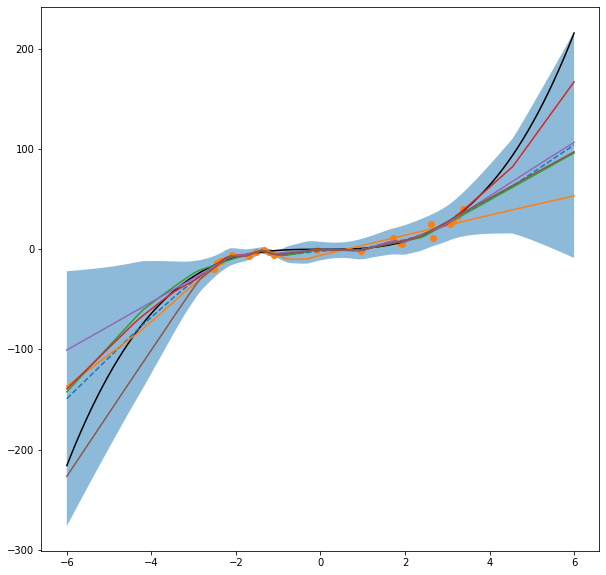

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.plot(Xtest, f(Xtest), c='k')
ax.plot(Xtest, ensemble_mean, ls='--')
ax.plot(Xtest, ensemble_predictions[:,:,0].T)
stddev = jnp.sqrt(ensemble_var)*3
ax.fill_between(Xtest[:,0], ensemble_mean+stddev, ensemble_mean-stddev, alpha=0.5)
ax.scatter(Xtrain, Ytrain)

# Questions 

1. We talked about bootstrapping and bagging in class. How does the approach that you implemented above different from a usual bootstrap ensemble? **Explain** in words how deep ensemble depart from the classic methodology. What is the benefit of the adversarial noise compared to the naive approach and why do we bother about doing things this way?  

Traditional bootstrapping is an ensemble method that creates multiple datasets out of a single one by sampling it uniformely with replacement. Models are then trained on the newly generated datasets and aggregated as a single predictor. While the bagging of the models in an ensemble reduces overall variance and helps to avoid overfitting, the variety of models in the ensemble constitutes a kind of ''wisdom of the crowds'' that increases the ensembles average performance.

Deep ensembles add to the traditional bootstrap framework by aiming to give a better estimation of predictive uncertainty. Deep ensembles achieve this by defining a simple recipe (proper scoring rules, ensembling, etc) to follow that includes adversarial training. The training set is modified using the fast gradient sign method; examples are perturbed with random noise in the direction that would increase the loss of the model. This type of training is thought to smooth predictive distributions by increasing the likelihood of targets in the neighborhood around their respective example. 

2. **Modify** the function ``train_ensemble`` to implement a "naive" bootstrap approach where you resample the data only and use **MSE loss.**
3. **Plot** the resulting confidence intervals (three points of standard deviation). Discuss the results

In [ ]:
#2 NAIVE VERSION
def train_ensemble(key, dataset, num_models, eps_adversarial, step_size, num_steps):
  
  inputs, targets = dataset

  def adversarial_train(key):
    key, subkey = jax.random.split(key)
    _, init_params = init_fn(key, (-1,1))

    # Create new dataset using uniform sampling with replacement
    inputs = jnp.random.choice(inputs, size=inputs.size)
    dataset = (inputs, targets)

    # 3. Compute the MSE on the new dataset
    mse = jnp.sum((-targets)**2)  # TODO: complete loss
    
    return (dataset, mse)

  return jax.vmap(adversarial_train)(jax.random.split(key, num_models))


  #3 Plot
